FitSNAP is an atomistic machine learning package with a LAMMPS interface. We therefore must start by installing LAMMPS and FitSNAP.




# Step 1: Install LAMMPS and FitSNAP

In [1]:
# install LAMMPS with Python interface

!apt-get update
!apt install -y cmake build-essential git ccache openmpi-bin libopenmpi-dev python3.8-venv
!pip install --upgrade pip
!pip install numpy torch scipy virtualenv psutil pandas tabulate mpi4py Cython sklearn
%cd /content
!rm -rf lammps
!git clone https://github.com/lammps/lammps.git lammps
%cd /content/lammps
!rm -rf build
!mkdir build
%cd build
!cmake ../cmake -DLAMMPS_EXCEPTIONS=yes \
               -DBUILD_SHARED_LIBS=yes \
               -DMLIAP_ENABLE_PYTHON=yes \
               -DPKG_PYTHON=yes \
               -DPKG_ML-SNAP=yes \
               -DPKG_ML-IAP=yes \
               -DPKG_ML-PACE=yes \
               -DPKG_SPIN=yes \
               -DPYTHON_EXECUTABLE:FILEPATH=`which python`
!make -j 2
!make install-python

# install FitSNAP

%cd /content
!rm -rf FitSNAP
!git clone https://github.com/FitSNAP/FitSNAP

# set environment variables

!$PYTHONPATH
%env PYTHONPATH=/env/python:/bin/bash:/content/FitSNAP
%env LD_LIBRARY_PATH=/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/content/lammps/build
!cp -r FitSNAP/fitsnap3lib /usr/lib/python3.8/fitsnap3lib

Ign:1 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu focal InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,479 kB]
Get:14 http://ppa.launchpad.net/

See more installation instructions at:

*   General FitSNAP setup: https://fitsnap.github.io/Installation.html
*   LAMMPS Python interface: https://docs.lammps.org/Python_install.html

# What's in this tutorial?



*   What is FitSNAP?
*   Overview of software components
*   Simple example with linear regression
*   Extracting fitting data (atomic environment descriptors)
*   Simple example with neural network regression
*   Using fitted potentials in LAMMPS
*   Advanced/development topic on new/custom neural network architectures




See more information on the doc page: https://fitsnap.github.io/ 

# What are we trying to achieve?

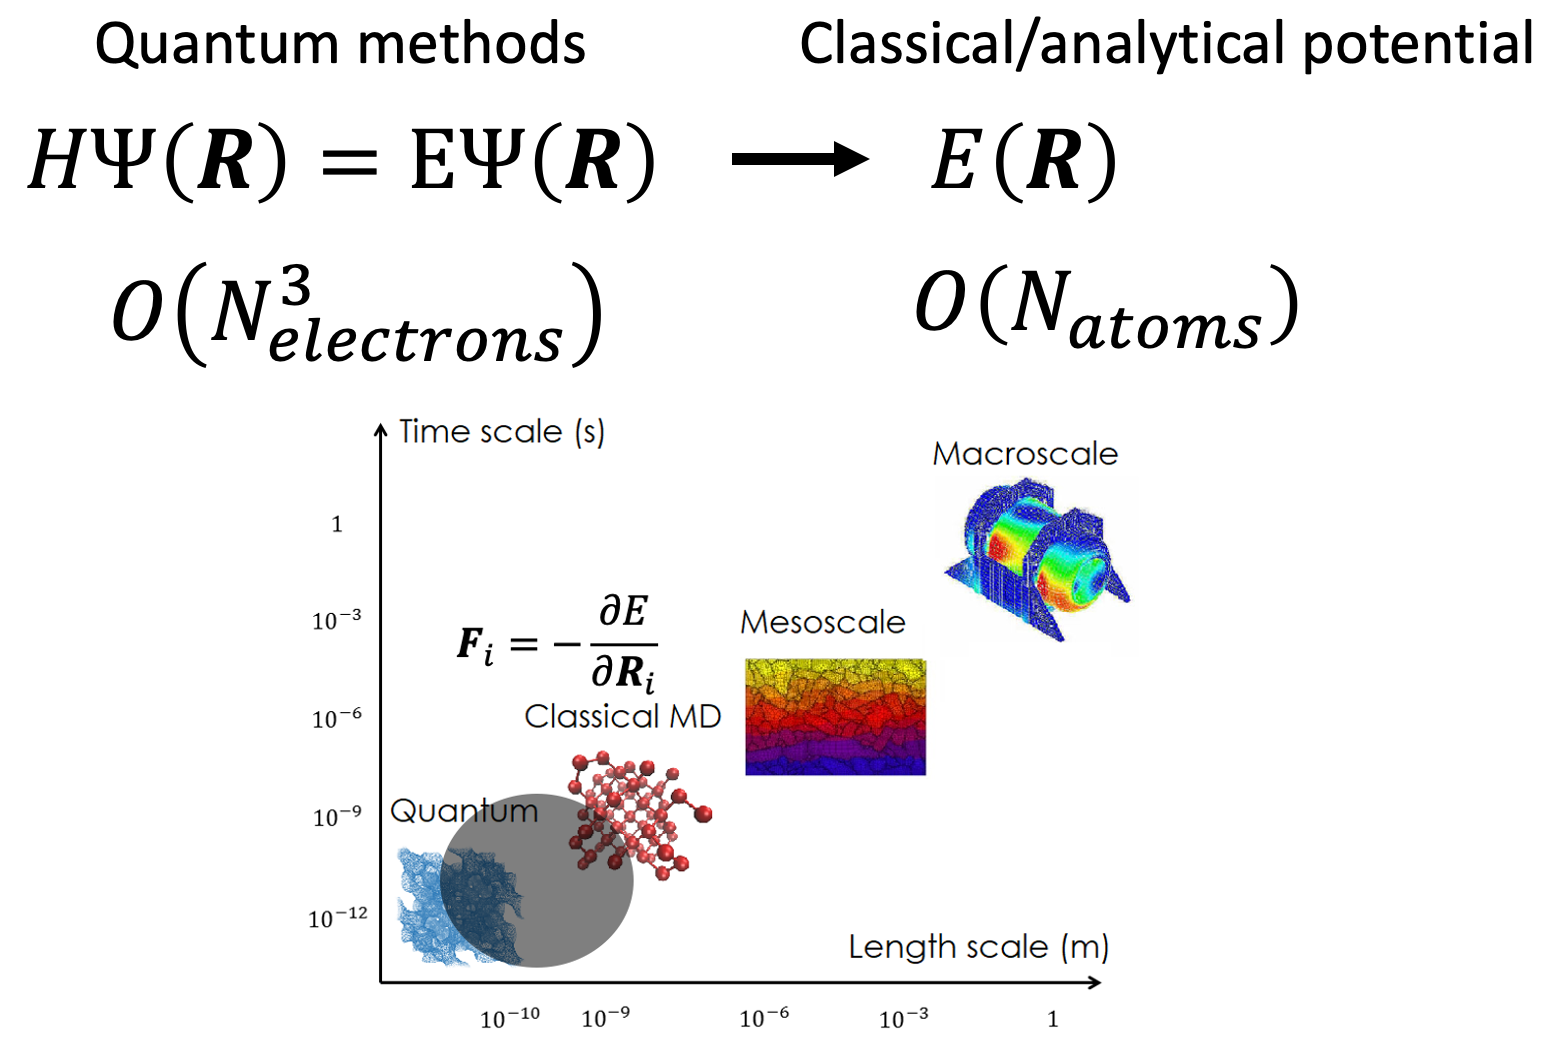

# The FitSNAP-LAMMPS ecosystem for constructing & deconstructing potentials

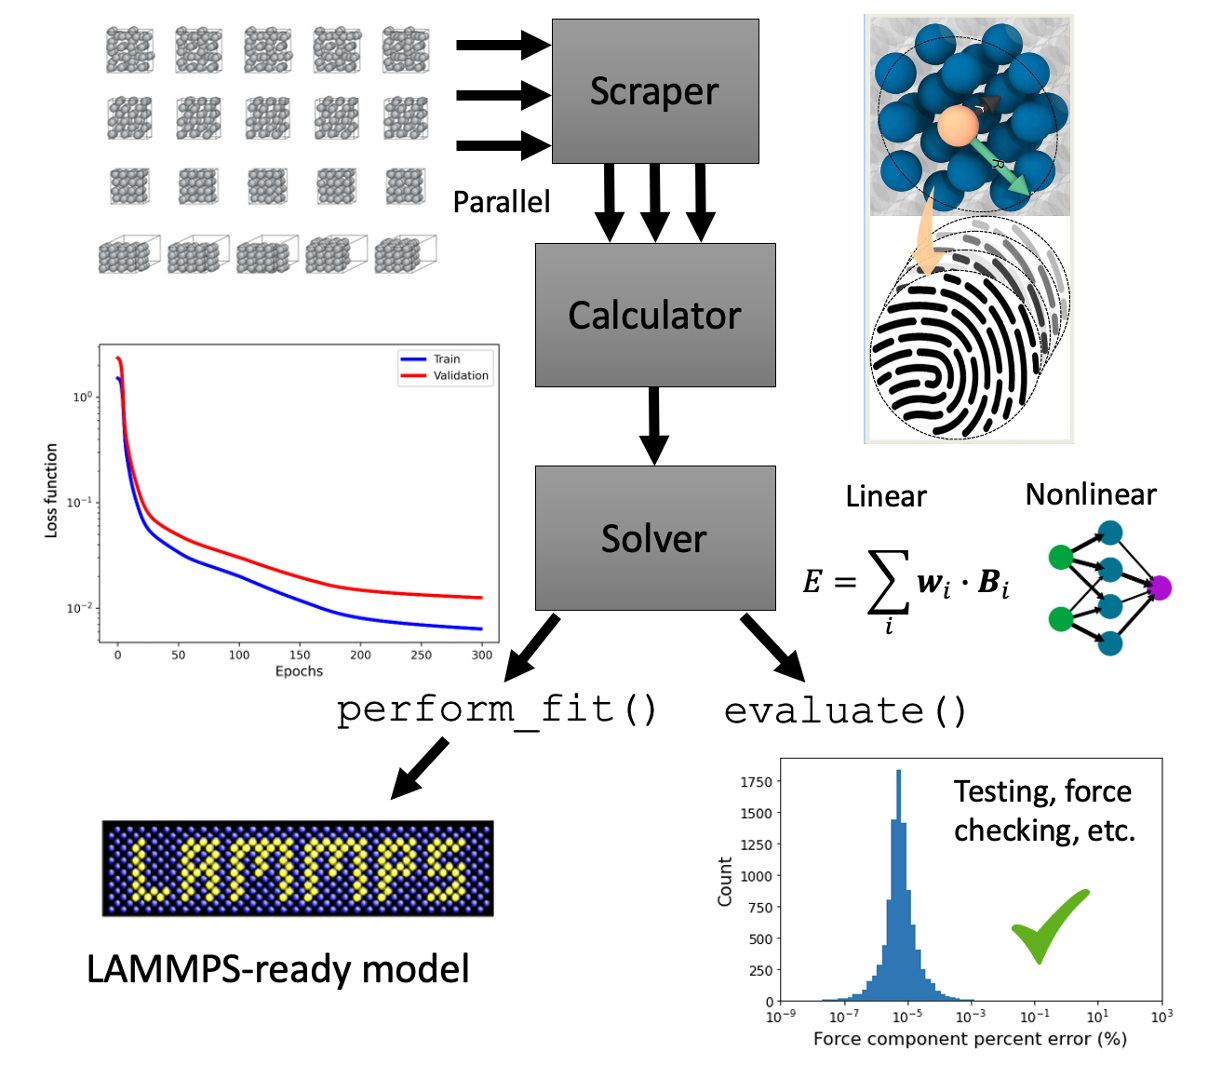

# How to use this notebook

*   Get familiar with Colab environment, we can run Python and Bash!
*   We will keep this Colab notebook updated as the code changes. Please refer to it for future use.
*   You can modify the setup procedures here for your own machine; hardest part is properly installing LAMMPS with Python.

In [ ]:
!which python
!python --version

/usr/local/bin/python
Python 3.7.14


# Check if Python-LAMMPS is working

This is the bare minimum requirement to use FitSNAP

In [ ]:
import lammps
lmp = lammps.lammps()
print(lmp)

If no errors, we're good to!

# Stay updated with the newest version using git

In [ ]:
%cd /content/FitSNAP
!git fetch
!git pull

/content/FitSNAP
Already up to date.


# Fit linear SNAP for tantalum

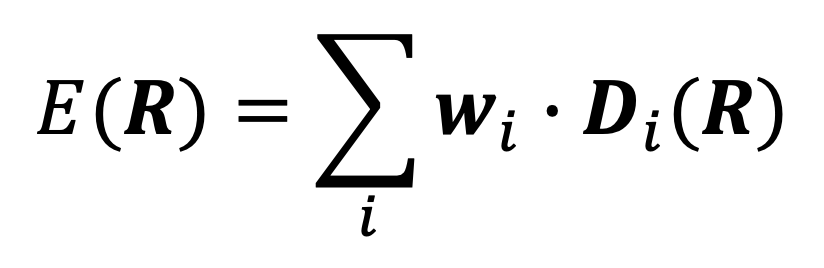

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

/content/FitSNAP/examples/Ta_Linear_JCP2014



Training data is stored in either XYZ or JSON files, e.g. see XYZ files:

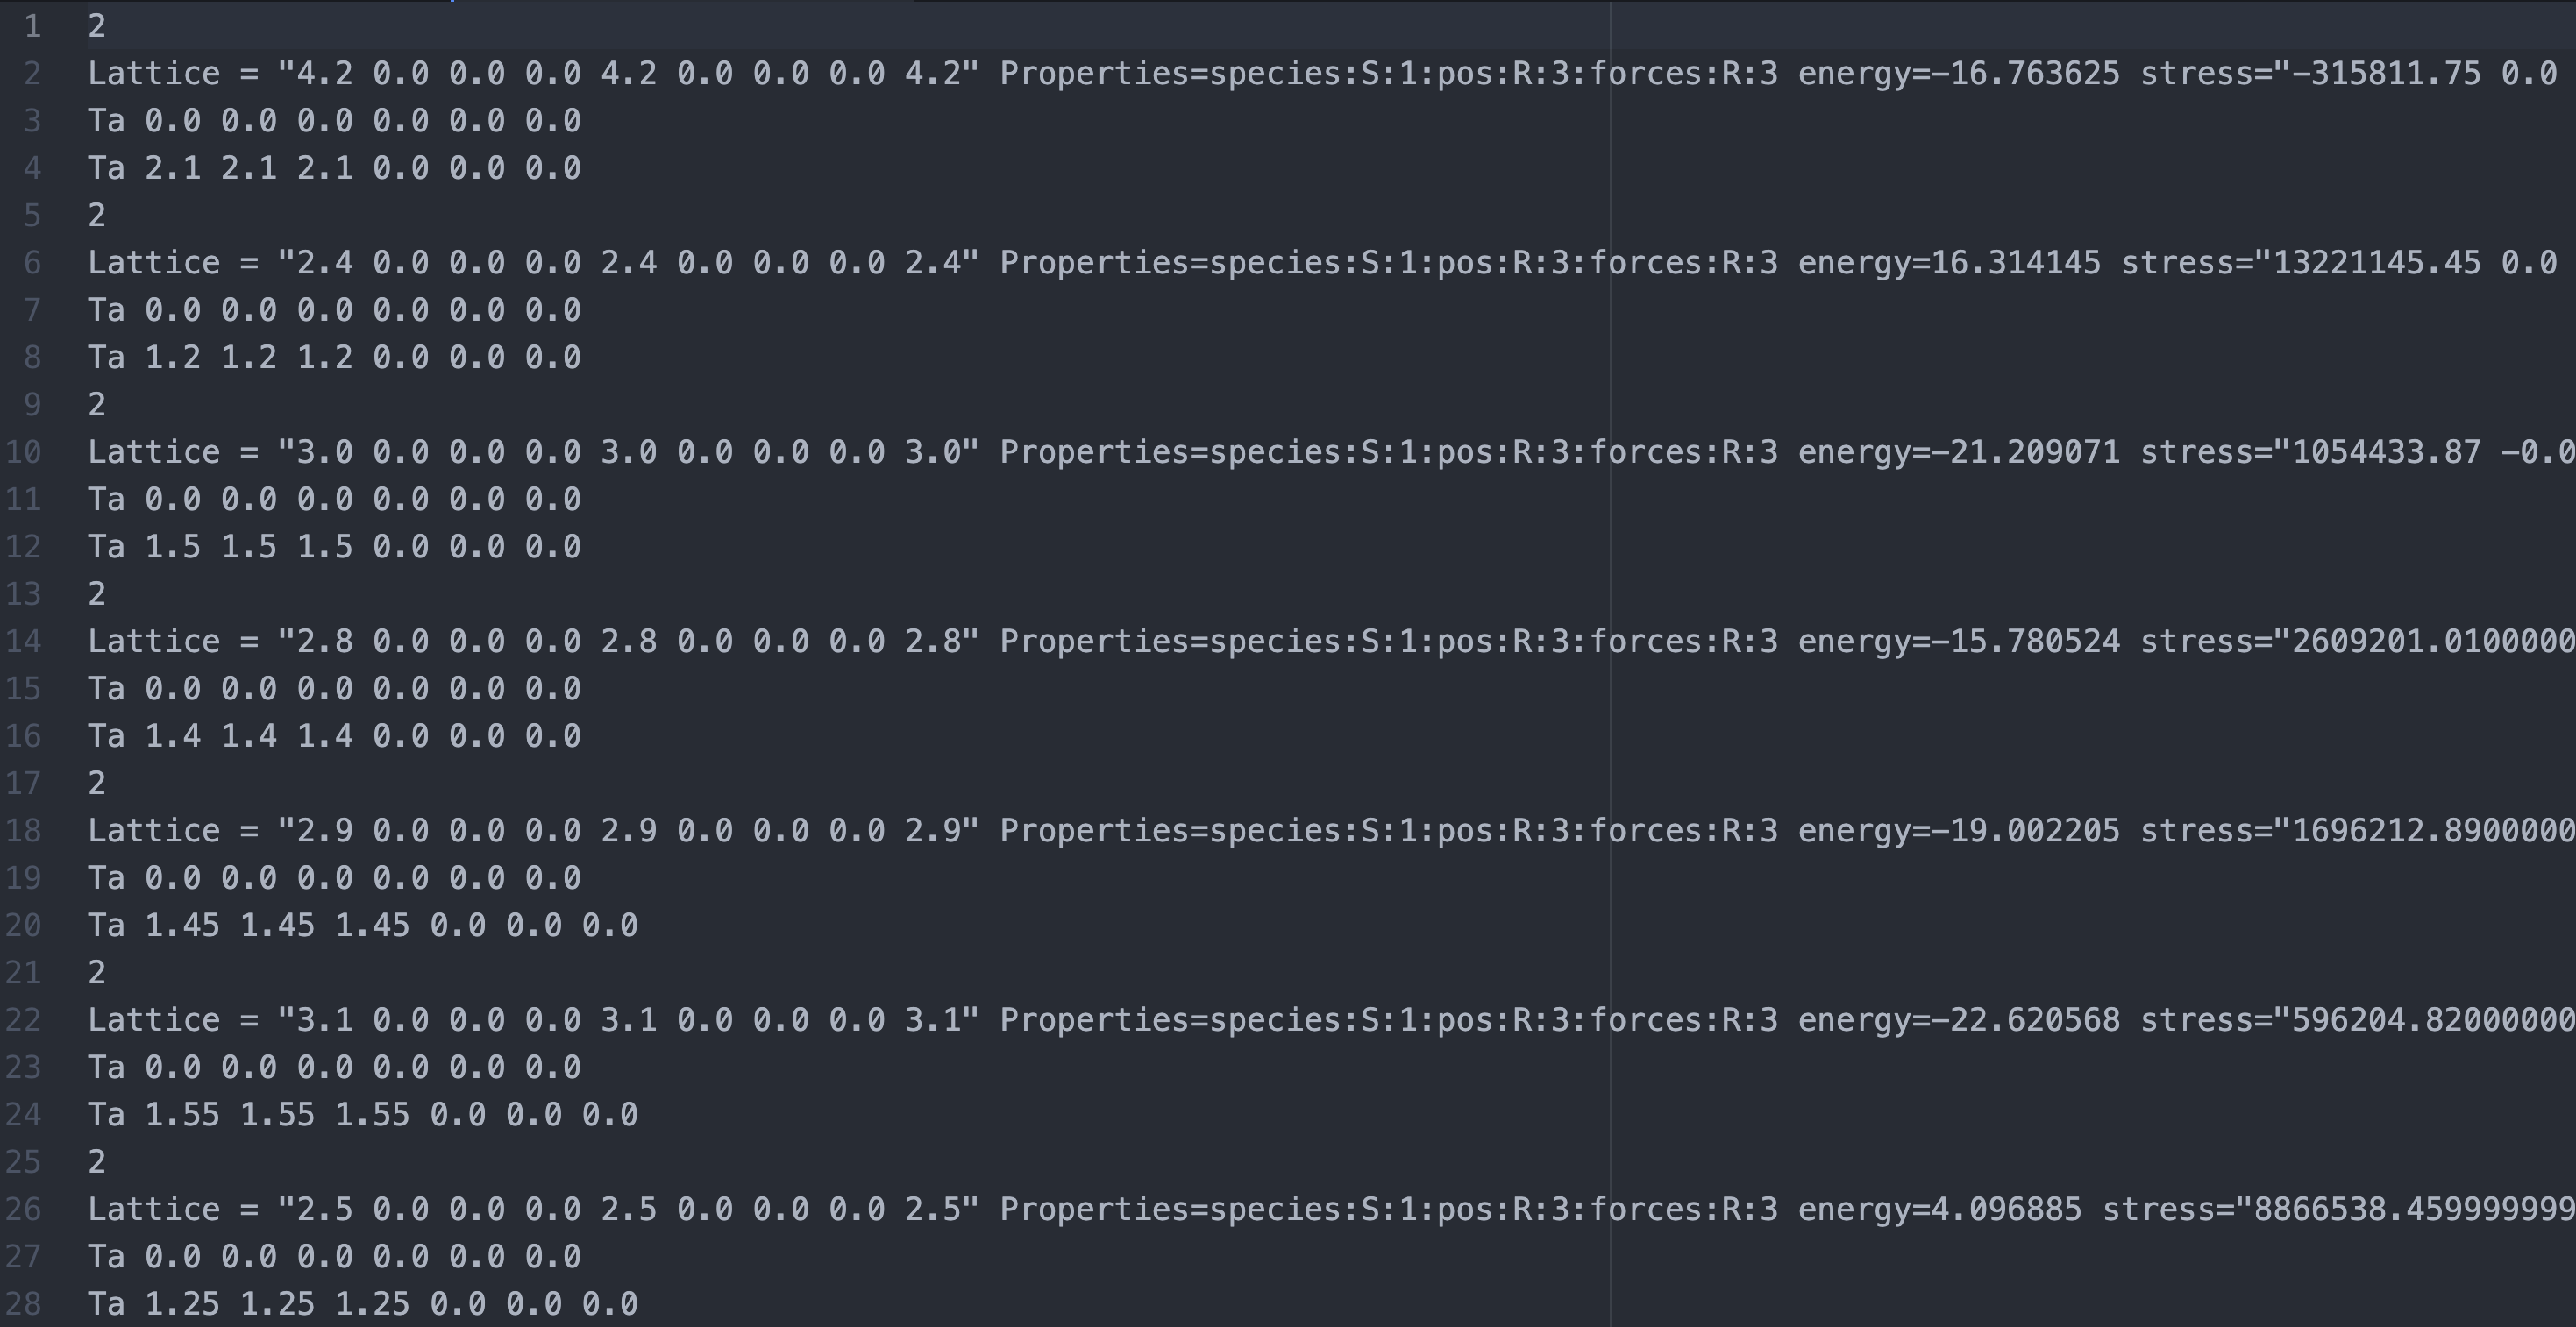

See `FitSNAP/tools` for scripts to convert VASP calculations to JSON.



*   We start with running FitSNAP as an executable. 
*   The general command is `mpirun -np P python -m fitsnap3 input.in`
*   Look at input script in file browser. 



In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014
# need to append --allow-run-as-root option to mpirun in Colab
#!mpirun --allow-run-as-root -np 2 python -m fitsnap3 Ta-example.in --overwrite

!python -m fitsnap3 Ta-example.in --overwrite

/content/FitSNAP/examples/Ta_Linear_JCP2014

    ______ _  __  _____  _   __ ___     ____  
   / ____/(_)/ /_/ ___/ / | / //   |   / __ \ 
  / /_   / // __/\__ \ /  |/ // /| |  / /_/ /
 / __/  / // /_ ___/ // /|  // ___ | / ____/ 
/_/    /_/ \__//____//_/ |_//_/  |_|/_/      

-----23Sep22------
Reading input...
Finished reading input
------------------
mpi4py version:  3.1.3
numpy version:  1.21.6
scipy version:  1.7.3
pandas version:  1.3.5
LAMMPS (15 Sep 2022)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
-----------
Total wall time: 0:00:00
Using LAMMPSSNAP as FitSNAP calculator
Displaced_A15 : Detected  9  fitting on  9  testing on  0
Displaced_BCC : Detected  9  fitting on  9  testing on  0
Displaced_FCC : Detected  9  fitting on  9  testing on  0
Elastic_BCC : Detected  100  fitting on  100  testing on  0
Elastic_FCC : Detected  100  fitting on  100  testing on  0
GSF_110 : Detected  22  fitting on  22  

Look at the output

In [ ]:
!ls

20May21_Standard      FitSNAP.df  Ta-example.in		Ta_pot.snapparam
anl		      JSON	  Ta-example-nodump.in	Test_Set_Example
compare_snapcoeff.py  log.lammps  Ta_metrics.md		Truth-Ref.npy
Descriptors.npy       README.md   Ta_pot.snapcoeff	Weights.npy


Linear models output a Pandas dataframe `FitSNAP.df`, which has information about the fit. 

Errors are included in `Ta_metrics.md` for each group, but we can also use the FitSNAP library to help us process/analyze the dataframe.


Let's look at what's in the dataframe:

*   First 31 columns are the SNAP bispectrum components used in the fitting matrix.
*   `truths` are the target values (e.g. energy, force, stress)
*   `preds` are the model values
*   `weights` are the user-defined weighting factors
*   `Groups` designate which user-defined group this row belongs to
*   `Configs` are the filenames associated with particular rows
*   `Row_Type` tells which rows are `Energy`, `Force`, or `Stress` rows
*   `Atom_I` is the atom index associated with a row
*   `Testing` are bools designating which rows are used for testing (not training)
*   `Atom_Type` designate which `Force` rows belong to a certain atom type



In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

# import FitSNAP library tools for dataframe analysis

from fitsnap3lib.tools.dataframe_tools import DataframeTools

# make a dataframe tool object, which reads in a file or a dataframe object

dataframe_tool = DataframeTools("FitSNAP.df")
df = dataframe_tool.read_dataframe()

# look at the dataframe

from google.colab import data_table
data_table.enable_dataframe_formatter()
df

/content/FitSNAP/examples/Ta_Linear_JCP2014


,0,1,2,3,4,5,6,7,8,9,...,30,truths,preds,weights,Groups,Configs,Row_Type,Atom_I,Testing,Atom_Type
0,1.0,100.894997,2.777151e+00,6.349960e-01,8.202120e+00,-2.939264e+00,1.047032e+00,1.261421e+00,6.486445e+01,-2.654052e+00,...,1.878329e+01,-16.596642,-1.659922e+01,1.000000e+02,Displaced_A15,A15_4.json,Energy,0,False,0
1,0.0,-0.187214,-7.241934e-01,-2.225528e-01,3.545322e+00,5.175955e-01,2.913078e-01,2.784828e-01,-1.555544e+01,-1.492475e-01,...,3.355309e+00,-0.039368,-4.633319e-02,1.000000e+00,Displaced_A15,A15_4.json,Force,0,False,1
2,0.0,1.970503,7.167194e-02,-5.388715e-01,2.053492e+00,6.300687e-01,1.927118e-01,7.460918e-01,-1.302305e+01,1.467906e+00,...,-3.688975e+00,-0.360229,-4.535569e-01,1.000000e+00,Displaced_A15,A15_4.json,Force,0,False,1
3,0.0,1.414332,1.749077e-01,1.708283e-01,-6.646379e-01,-4.562434e-01,4.600721e-01,2.280361e-01,1.370566e+00,-2.981147e-01,...,9.560575e-01,0.084948,1.518371e-01,1.000000e+00,Displaced_A15,A15_4.json,Force,0,False,1
4,0.0,0.850244,-2.833948e-02,-1.635474e-01,-2.214613e+00,1.237122e-01,-3.761794e-01,-2.944567e-01,1.044863e+01,5.231485e-01,...,-5.960400e+00,-0.128127,-1.845852e-01,1.000000e+00,Displaced_A15,A15_4.json,Force,1,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15208,0.0,762898.121392,-1.558541e+05,-2.246088e+05,1.150929e+06,-2.428488e+05,7.426089e+05,3.959856e+05,1.196522e+05,-3.147467e+05,...,-8.780784e+05,-303023.735375,-5.453296e+04,1.000000e-09,Volume_FCC,FCC_5.6.json,Stress,0,False,0
15209,0.0,762898.121392,-1.558541e+05,-2.246088e+05,1.150929e+06,-2.428488e+05,7.426089e+05,3.959856e+05,1.196522e+05,-3.147467e+05,...,-8.780784e+05,-303023.735375,-5.453296e+04,1.000000e-09,Volume_FCC,FCC_5.6.json,Stress,0,False,0
15210,0.0,0.000000,4.051506e-12,4.051506e-12,-1.620602e-11,-4.051506e-12,0.000000e+00,0.000000e+00,2.025753e-12,8.103012e-12,...,1.620602e-11,0.000000,2.678292e-12,1.000000e-09,Volume_FCC,FCC_5.6.json,Stress,0,False,0
15211,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.620602e-11,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.620602e-11,0.000000,3.887730e-12,1.000000e-09,Volume_FCC,FCC_5.6.json,Stress,0,False,0


Use dataframe tools to calculate errors:

In [ ]:
mae_energy_total = dataframe_tool.calc_error("Energy", "Training")
mae_force_total = dataframe_tool.calc_error("Force", "Training")
print("Energy MAE (eV/atom)      Force MAE (eV/A)")
print(f"{mae_energy_total} {mae_force_total}")

Energy MAE (eV)      Force MAE (eV/A)
0.11278674722618355 0.07575757670459735


This energy error might seem high, so it's good to view it in relation to the spread of target energies
in the plots below. It is possible to achieve much lower energy errors, but this potential was also 
optimized to external objective functions that mattered more than absolute energy agreement.

Add group argument to get errors of a particular group:

In [ ]:
mae_energy = dataframe_tool.calc_error("Energy", "Training", "Volume_BCC")
mae_force = dataframe_tool.calc_error("Force", "Training", "Volume_BCC")
print("Energy MAE (eV/atom)      Force MAE (eV/A)")
print(f"{mae_energy} {mae_force}")

Energy MAE (eV)      Force MAE (eV/A)
0.3285981181749092 3.856080502920256e-15


Import FitSNAP `config` object to get information about input file, like the groups we fit to.

*   `config` contains information on the sections defined in the input script.
*   Examples:
*   `config.sections['BISPECTRUM']` contains bispectrum/descriptor settings.
*   `config.sections['GROUPS'].group_table['Liquid']['eweight']` contains energy weights associated with the `Liquid` group.
*   See more on Config files at https://docs.python.org/3/library/configparser.html

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

# import fitsnap config to get group table

from fitsnap3lib.io.input import Config
from fitsnap3lib.parallel_tools import ParallelTools
pt = ParallelTools()
pt.check_fitsnap_exist = False
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])

"""
Loop over groups and calculate errors.

Note that we could also do this using the groups in the dataframe, but we 
illustrate the use of the group table here.
"""

print(f"{'Group':15} {'Energy MAE':3} {'Force MAE':3}")
for group in config.sections['GROUPS'].group_table:
    mae_energy_group = dataframe_tool.calc_error("Energy", "Training", group)
    mae_force_group = dataframe_tool.calc_error("Force", "Training", group)
    print(f"{group:15} {mae_energy_group:.3e} {mae_force_group:.3e}")

Group           Energy MAE Force MAE
Displaced_A15   2.358e-03 9.806e-02
Displaced_BCC   1.884e-03 1.434e-01
Displaced_FCC   6.167e-04 5.741e-02
Elastic_BCC     6.411e-03 7.272e-05
Elastic_FCC     3.618e-03 9.642e-05
GSF_110         6.524e-03 2.650e-02
GSF_112         8.684e-03 5.698e-02
Liquid          5.668e-03 3.538e-01
Surface         1.352e-02 4.760e-02
Volume_A15      2.458e-01 4.645e-15
Volume_BCC      3.286e-01 3.856e-15
Volume_FCC      8.121e-01 3.256e-15


FitSNAP library has built-in tools for plotting dataframe quantities.

`dataframe_tools.plot_agreement(quantity="Energy", fitting_set="Training", legend=True, mode="Distribution")`

Sometimes it's useful to plot the data to see what the outliers are.

This saves an image file called `energy_agreement.png` or `force_agreement.png`

In [ ]:
dataframe_tool.plot_agreement("Energy", fitting_set="Training", mode="Linear")

Better way to view images in Colab:

In [ ]:
dataframe_tool.plot_agreement("Energy", fitting_set="Training", mode="Distribution")

from IPython.display import Image
Image('energy_agreement.png')

In [ ]:
dataframe_tool.plot_agreement("Force", fitting_set="Training", mode="Distribution")

Image('force_agreement.png')

Aside from the dataframe, FitSNAP also made LAMMPS-ready potential files.

*   `Ta_pot.snapcoeff`
*   `Ta_pot.snapcoeff`



In [ ]:
!ls

20May21_Standard      force_agreement.png   Ta_metrics.md
anl		      JSON		    Ta_pot.snapcoeff
compare_snapcoeff.py  log.lammps	    Ta_pot.snapparam
Descriptors.npy       README.md		    Test_Set_Example
energy_agreement.png  Ta-example.in	    Truth-Ref.npy
FitSNAP.df	      Ta-example-nodump.in  Weights.npy


We can use this to run MD or calculate errors on an entirely separate set, without performing fits.

### Using your potential with LAMMPS to test errors on another set.



*   When training, we calculate errors on the training set and a validation set.
*   Often it is useful to calculate errors on entirely different set (a "test set") after training.
*   We can use FitSNAP+LAMMPS Python libraries for this.
*   We will load our fitted potential into LAMMPS and calculate energies/forces, then compare to the test set.



In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014/

from fitsnap3lib.tools.lammps_tools import LammpsTools

# define pair style, input script, and test directory

pairstyle = """
            pair_style hybrid/overlay zbl 4.0 4.8 snap
            pair_coeff * * zbl 73 73
            pair_coeff * * snap Ta_pot.snapcoeff Ta_pot.snapparam Ta
            """
input_script = "Ta-example.in"
test_dir = "Test_Set_Example"

# create LammpsTools object

lmp_tools = LammpsTools(pairstyle, input_script, test_dir)

# calculate errors

errors = lmp_tools.calculate() # creates dictionary of errors

print(f"{'Group':20} {'Energy MAE':3} {'Force MAE':3}")
for group in errors:
    print(f"{group:20} {errors[group]['mae_energy']:.3e} {errors[group]['mae_force']:.3e}")

/content/FitSNAP/examples/Ta_Linear_JCP2014
Using LAMMPSSNAP as FitSNAP calculator
Displaced_FCC_Test : Detected  9  fitting on  9  testing on  0
Elastic_FCC_Test : Detected  100  fitting on  100  testing on  0
'decorated_scrape_configs' took 92.09 ms on rank 0
Group                Energy MAE Force MAE
Displaced_FCC_Test   2.874e-02 5.762e-02
Elastic_FCC_Test     1.509e-02 9.609e-05


The FitSNAP library does more than just process fitting data.

We can perform entire fits in library mode, offering a lot of flexibility.

### Perform fit in library mode

This is useful if you want to immediately screen for stability, for example when looping over fits. 

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

from fitsnap3lib.parallel_tools import ParallelTools
from fitsnap3lib.io.input import Config
pt = ParallelTools()
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])

# create a fitsnap object

from fitsnap3lib.fitsnap import FitSnap
snap = FitSnap()

# scrape configs, process configs, and perform the fit

snap.scrape_configs()
snap.process_configs()
snap.perform_fit()

# data frame is contained in snap.solver

snap.solver.df

This creates LAMMPS-ready potential files like running with the executable.

###Run MD in the same python script!

Use our LAMMPS-ready potential files immediately for MD.

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

# run MD

import lammps
lmp = lammps.lammps()

lammps_commands=\
"""
# initialize simulation

variable nsteps index 100
variable nrep equal 3
variable a equal 3.316
units           metal

# generate the box and atom positions using a BCC lattice

variable nx equal ${nrep}
variable ny equal ${nrep}
variable nz equal ${nrep}
boundary        p p p
lattice         bcc $a
region          box block 0 ${nx} 0 ${ny} 0 ${nz}
create_box      1 box
create_atoms    1 box
mass 1 180.88

# choose potential

pair_style hybrid/overlay zbl 4.0 4.8 snap
pair_coeff * * zbl 73 73
pair_coeff * * snap Ta_pot.snapcoeff Ta_pot.snapparam Ta

# setup output

thermo 100
thermo_style    custom step etotal temp pe
compute PE all pe

# set up NVE run

timestep 0.5e-3
neighbor 1.0 bin
neigh_modify once no every 1 delay 0 check yes

# run MD
velocity all create 300.0 4928459 loop geom
fix 1 all nve
run             ${nsteps}
"""

lmp.commands_string(lammps_commands)

# observe potential energy/stability over a 0.5 ps period

for i in range(10):
    pe = lmp.numpy.extract_compute("PE", 0, 0)
    print(pe)
    lmp.command("run 100")

***We can perform fits, access to the detailed errors in the dataframe, and run MD to check for stability, all in a single Python script.***

This provides a lot of flexibility/possibility for various training methods.

For example, one could loop over many fits while tweaking hyper-parameters.

### Loop over fits


*   This can be done to optimize hyperparameters for example.
*   Use the `config` object to tweak settings for optimization.
*   `config` contains information on the sections defined in the input script.
*   Examples:
*   `config.sections['BISPECTRUM']` contains bispectrum/descriptor settings.
*   `config.sections['GROUPS'].group_table['Liquid']['eweight']` contains energy weights associated with the `Liquid` group.
*   See more on Config files at https://docs.python.org/3/library/configparser.html

Define functions that we'll use for looping over fits:

In [ ]:
import numpy as np

def change_descriptor_hyperparams(config):
    """
    Modify descriptor hyperparams associated with a certain config object.

    Attributes
    ----------

    config: FitSNAP Config object
        Holds input settings/hyperparameters to tweak

    Returns
    -------

    config: modified Config object
    """

    # twojmax, wj, and radelem are lists of chars

    config.sections['BISPECTRUM'].twojmax = ['6']
    config.sections['BISPECTRUM'].wj = ['1.0']
    config.sections['BISPECTRUM'].radelem = ['0.5']

    # rcutfac and rfac0 are doubles

    config.sections['BISPECTRUM'].rcutfac = 4.67637
    config.sections['BISPECTRUM'].rfac0 = 0.99363

    # after changing twojmax, need to generate_b_list to adjust all other variables

    config.sections['BISPECTRUM']._generate_b_list()

    return config

def change_weights(config, data):
    """
    Change fitting weights associated with each configuration of atoms.

    Attributes
    ----------

    config: FitSNAP Config object
        Holds input setting data

    data: FitSNAP data object
        Holds configuration data, positions, forces, weights, for each configuration of atoms

    Returns
    -------

    config: modified Config object

    data: modified data object
    """

    # loop through all group weights in the group_table and change the value

    for key in config.sections['GROUPS'].group_table:
        for subkey in config.sections['GROUPS'].group_table[key]:
            if ("weight" in subkey):
                # change the weight
                config.sections['GROUPS'].group_table[key][subkey] = np.random.rand(1)[0]

    # loop through all configurations and set a new weight based on the group table

    for i, configuration in enumerate(data):
        group_name = configuration['Group']
        new_weight = config.sections['GROUPS'].group_table[group_name]
        for key in config.sections['GROUPS'].group_table[group_name]:
            if ("weight" in key):
                # set new weight 
                configuration[key] = config.sections['GROUPS'].group_table[group_name][key]

    return(config, data)

Use these functions to loop over fits while changing descriptors settings and/or weights:

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

from fitsnap3lib.tools.dataframe_tools import DataframeTools
from fitsnap3lib.parallel_tools import ParallelTools
from fitsnap3lib.io.input import Config
config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])
from fitsnap3lib.fitsnap import FitSnap

ngenerations = 2
for g in range(0,ngenerations):

    # instantiate library objects

    pt = ParallelTools()
    config = Config(arguments_lst = ["Ta-example.in", "--overwrite"])
    snap = FitSnap()

    # scrape configs

    snap.scraper.scrape_groups()
    snap.scraper.divvy_up_configs()
    snap.data = snap.scraper.scrape_configs()

    # change the bispectrum hyperparams

    config = change_descriptor_hyperparams(config)

    # change weight hyperparams

    (config, snap.data) = change_weights(config, snap.data)
    
    # process configs with new hyperparams
    # set indices to zero for populating new data array

    snap.calculator.shared_index=0
    snap.calculator.distributed_index=0 
    snap.process_configs()
     
    # perform a fit and gather dataframe with snap.solver.error_analysis()

    snap.solver.perform_fit()
    snap.solver.fit_gather()
    # need to empty errors before doing error analysis
    snap.solver.errors = []
    snap.solver.error_analysis()

    # now we have the dataframe, calculate errors with it

    df_tool = DataframeTools(snap.solver.df)
    mae_energy = df_tool.calc_error("Energy", "Training")
    mae_force = df_tool.calc_error("Force", "Training")

    print(f"---------- Generation {g} Force MAE: {mae_force} Energy MAE: {mae_energy}")

Can get creative here:

*   Run MD each iteration and train for stability, or some other property.
*   Optimize against some other external validation set, chosen by whatever means.
*   Any optimization approach can be wrapped around this framework.

*These capabilities demonstrate the flexibility of fitting we can have, but what about analyzing the data that we fit to?*

### Extracting per-atom SNAP descriptors

This is useful if you want to inspect the phase space of your descriptors, do PCA analysis to see how similar configurations are, etc.

Make the following changes to the input script: 

*   `bikflag = 1` in `[BISPECTRUM]`
*   `bzeroflag = 1` in `[BISPECTRUM]` (required by `per_atom_energy = 1`)
*   `per_atom_energy = 1` in `[CALCULATOR]`

Calculate per-atom descriptors without performing a fit:

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014 
!python -m fitsnap3 Ta-example.in --overwrite --nofit

Now our dataframe contains per-atom descriptors (we have more rows than before)


In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

dataframe_tool = DataframeTools("FitSNAP.df")
df = dataframe_tool.read_dataframe()
df

,0,1,2,3,4,5,6,7,8,9,...,28,29,truths,weights,Groups,Configs,Row_Type,Atom_I,Testing,Atom_Type
0,1.394503e+00,-0.005576,-0.041525,3.776393e-02,-0.094727,-0.035786,-0.059269,9.826018e-01,-0.118482,8.329407e-02,...,9.724227e-02,2.771061e-01,-1.659144e+01,1.000000e+02,Displaced_A15,A15_9.json,Energy,0,False,1
1,1.446173e+00,-0.006016,-0.042312,2.667406e-02,-0.092106,-0.037508,-0.060506,1.011099e+00,-0.118609,7.483574e-02,...,1.045078e-01,2.944053e-01,0.000000e+00,0.000000e+00,Displaced_A15,A15_9.json,Energy,1,False,1
2,1.543011e+00,0.018692,-0.034007,1.095122e-01,-0.116839,-0.025392,-0.056706,9.063065e-01,-0.119496,9.475957e-02,...,6.877058e-02,1.448796e-01,0.000000e+00,0.000000e+00,Displaced_A15,A15_9.json,Energy,2,False,1
3,1.547402e+00,0.017512,-0.034372,1.097481e-01,-0.115712,-0.026084,-0.056902,8.973633e-01,-0.119526,9.179622e-02,...,7.185572e-02,1.447689e-01,0.000000e+00,0.000000e+00,Displaced_A15,A15_9.json,Energy,3,False,1
4,1.576101e+00,0.014637,-0.035633,1.083240e-01,-0.112580,-0.028665,-0.057787,8.907764e-01,-0.118758,8.353084e-02,...,8.705536e-02,1.479679e-01,0.000000e+00,0.000000e+00,Displaced_A15,A15_9.json,Energy,4,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18387,2.574452e+07,103483.953525,-213188.870609,-3.287883e+06,740973.112373,-895467.174917,-710162.094833,1.068318e+07,-729943.744015,-1.908682e+06,...,2.694067e+06,1.374933e+06,-1.142287e+06,1.000000e-08,Displaced_BCC,BCC_5.json,Stress,0,True,0
18388,2.568642e+07,97173.698432,-214318.905396,-3.337882e+06,745743.323912,-906460.554654,-728453.029857,1.091510e+07,-717306.148504,-1.894908e+06,...,2.659767e+06,1.607066e+06,-1.145466e+06,1.000000e-08,Displaced_BCC,BCC_5.json,Stress,0,True,0
18389,1.064792e+05,20839.109384,8470.482076,9.239319e+04,-26681.632302,23329.988991,14879.361535,-1.371612e+05,-6902.393948,1.663727e+04,...,3.469717e+04,4.698035e+04,-5.297936e+03,1.000000e-08,Displaced_BCC,BCC_5.json,Stress,0,True,0
18390,1.276642e+04,6553.757330,6135.790567,2.534322e+04,-12408.527001,16949.475185,1648.794151,1.374608e+04,-258.807779,1.130381e+04,...,5.588126e+04,8.909246e+04,-3.179579e+03,1.000000e-08,Displaced_BCC,BCC_5.json,Stress,0,True,0


We can use this to visualize how similar certain groups/configurations are to each other. 

E.g. t-SNE analysis (thanks Logan!) 

Takes ~5 min to plot

In [ ]:
%cd /content/FitSNAP/examples/Ta_Linear_JCP2014

# import dataframe tools

from fitsnap3lib.tools.dataframe_tools import DataframeTools

# create dataframe tool object

df_tool = DataframeTools("FitSNAP.df")

# read dataframe and plot t-SNE

df = df_tool.read_dataframe()
df_tool.plot_tsne(num_descriptors = 30, point_size=0.2)

This can take a few min to run... Output looks like this:
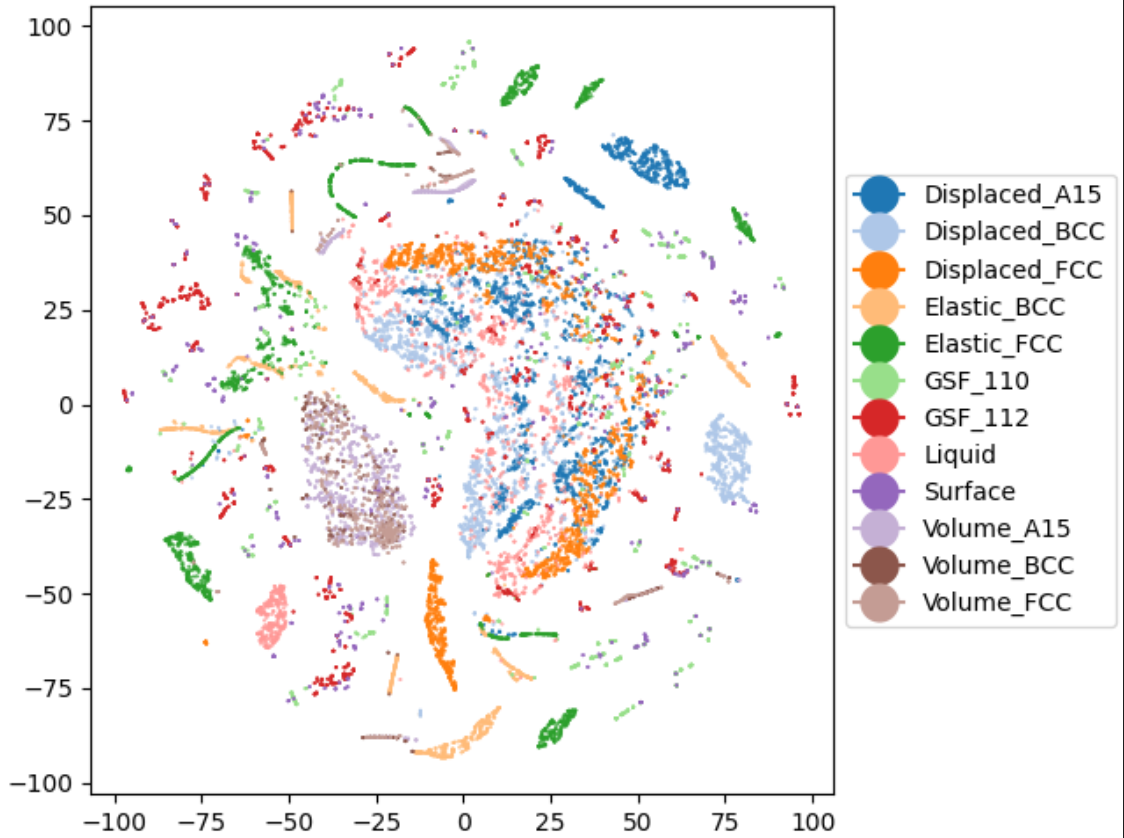

We also need per-atom descriptors for NN potentials, which we will do next.

# Nonlinear potential fitting

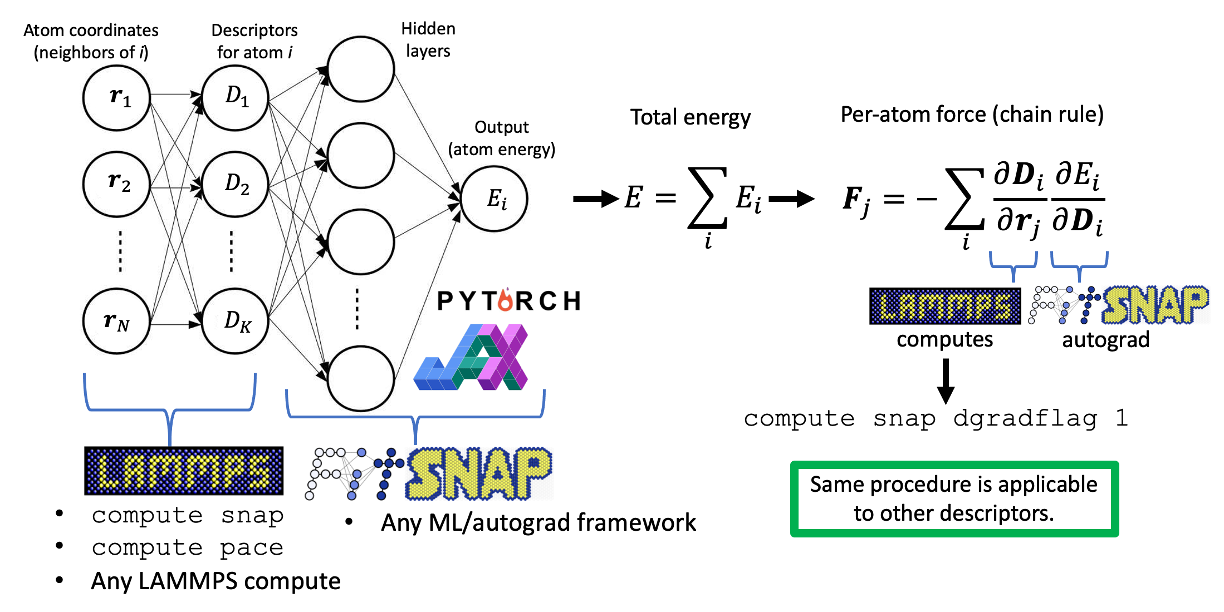

# Fit NN-SNAP for tantalum


*   Look at input script in `/content/FitSNAP/examples/Ta_PyTorch_NN/Ta-example.in`
*   See more on PyTorch models at https://fitsnap.github.io/Pytorch.html



In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN

!python -m fitsnap3 Ta-example.in --overwrite

Look at loss vs. epochs

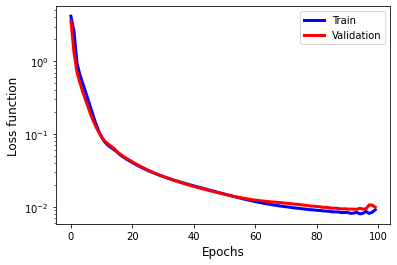

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN

from matplotlib import pyplot as plt
import numpy as np

# matplotlib settings

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# load loss vs. epochs file

dat = np.loadtxt("loss_vs_epochs.dat")

# plot

plt.plot(dat[:,0], dat[:,1], 'b-', linewidth=3)
plt.plot(dat[:,0], dat[:,2], 'r-', linewidth=3)
plt.xlabel("Epochs")
plt.ylabel(r'Loss function')
plt.yscale('log')
plt.legend(["Train", "Validation"])
plt.show("error_vs_epochs.png")

Look at training and validation errors for forces and energies

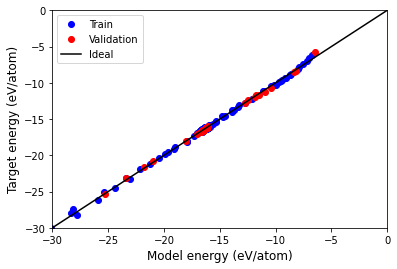

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN

from IPython.display import Image

python plot_comparison.py
Image('energy_comparison.png')

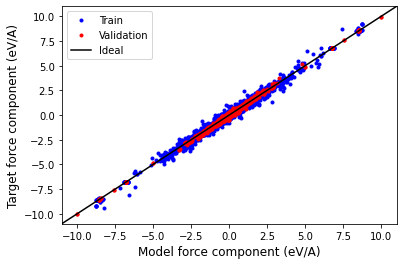

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN

from IPython.display import Image

python plot_comparison.py
Image('energy_comparison.png')

This fit created a LAMMPS-ready PyTorch file for running MD via the ML-IAP package.

In [ ]:
!ls

dump.xyz  log.lammps	       README.md
in.run	  mliap_pytorch_Ta.py  Ta.mliap.descriptor


See the LAMMPS input script in /content/FitSNAP/examples/Ta_PyTorch_NN/MD/in.run

### Run MD with Ta NN-SNAP

In [ ]:
%cd /content/FitSNAP/examples/Ta_PyTorch_NN/MD

!/content/lammps/build/lmp < in.run

# Multi-element NNs

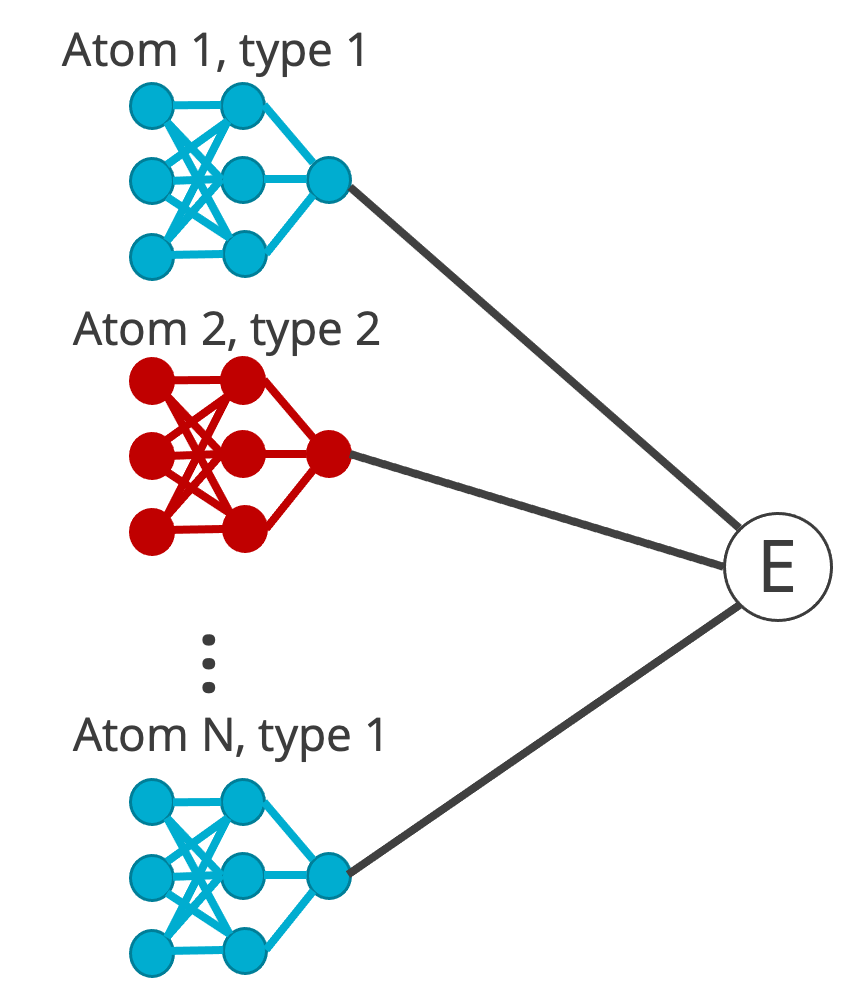

Example: Fit to 5200 configurations in the WBe set.

Time to fit (on Colab): ~10 min

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN

!mpirun --allow-run-as-root -np 4 python -m fitsnap3 WBe-example.in --overwrite

Look at loss vs. epochs:

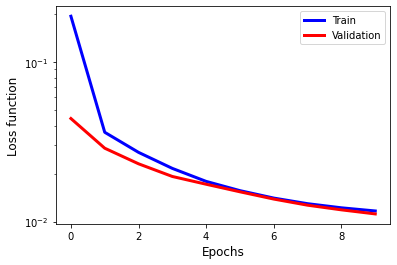

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN

dat = np.loadtxt("loss_vs_epochs.dat")

plt.plot(dat[:,0], dat[:,1], 'b-', linewidth=3)
plt.plot(dat[:,0], dat[:,2], 'r-', linewidth=3)
plt.xlabel("Epochs")
plt.ylabel(r'Loss function')
plt.yscale('log')
plt.legend(["Train", "Validation"])
plt.show("error_vs_epochs.png")

We could have kept fitting for longer, but let's see how the errors are.

Visualize training and validation errors for energies:

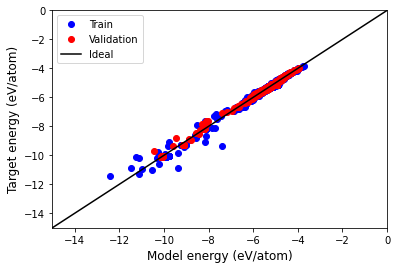

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN

from IPython.display import Image

python plot_comparison.py
Image('energy_comparison.png')

Visualize training and validation errors for forces:

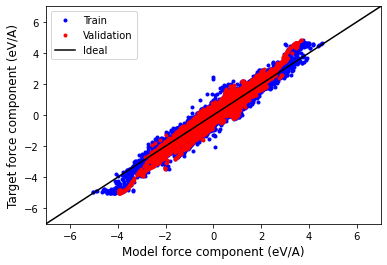

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN

Image('force_comparison.png')

We also created a `FitTorch_pytorch.pt` file which is used by LAMMPS for MD.

### Run MD with WBe NN-SNAP

In [ ]:
%cd /content/FitSNAP/examples/WBe_PyTorch_NN/MD

!/content/lammps/build/lmp < in.run

# NN training computational benchmarks

Training computation scales roughly as `num_atoms*num_neighs`.

Rough benchmarks for CPU training:

*   Ta example - 363 configs, ~12 atoms per config, batch_size=4: 0.3 s/epoch
*   WBe example - ~5000 configs, ~24 atoms per config, batch_size=4: 13 s/epoch
*   W entropy dataset - 10k configs, ~30 atoms per config, batch_size=4: 22 s/epoch
*   Svetoslav set - 42k configs, ~40 atoms per config, batch_size=4, ***cutoff = 15 A***: 5 min/epoch

### GPU acceleration

If you have a GPU with CUDA and PyTorch installed, the NN training will automatically use it. 

There is one way to observe GPU speedups: give it a lot of operations to parallelize over. 

This is achieved with:

1.   Large batch size
2.   Large model size

Our examples used neither, but we are free to experiment here, and optimize settings for performance.





# Advanced/Development Topics: Custom Calculator

We can extract pure LAMMPS positions and neighlist

This allows one to define their own descriptor and Solver using these positions.

This opens up many possibilities when combined with differentiable programming.

See more on adding your own calculator and solver at: https://fitsnap.github.io/Executable.html

# End-to-End Differentiable Potential Optimization

***End-to-end differentiable models can have all differentiable parameters to enable joint optimization from input to output.***

That means less worrying about hyperparameters!



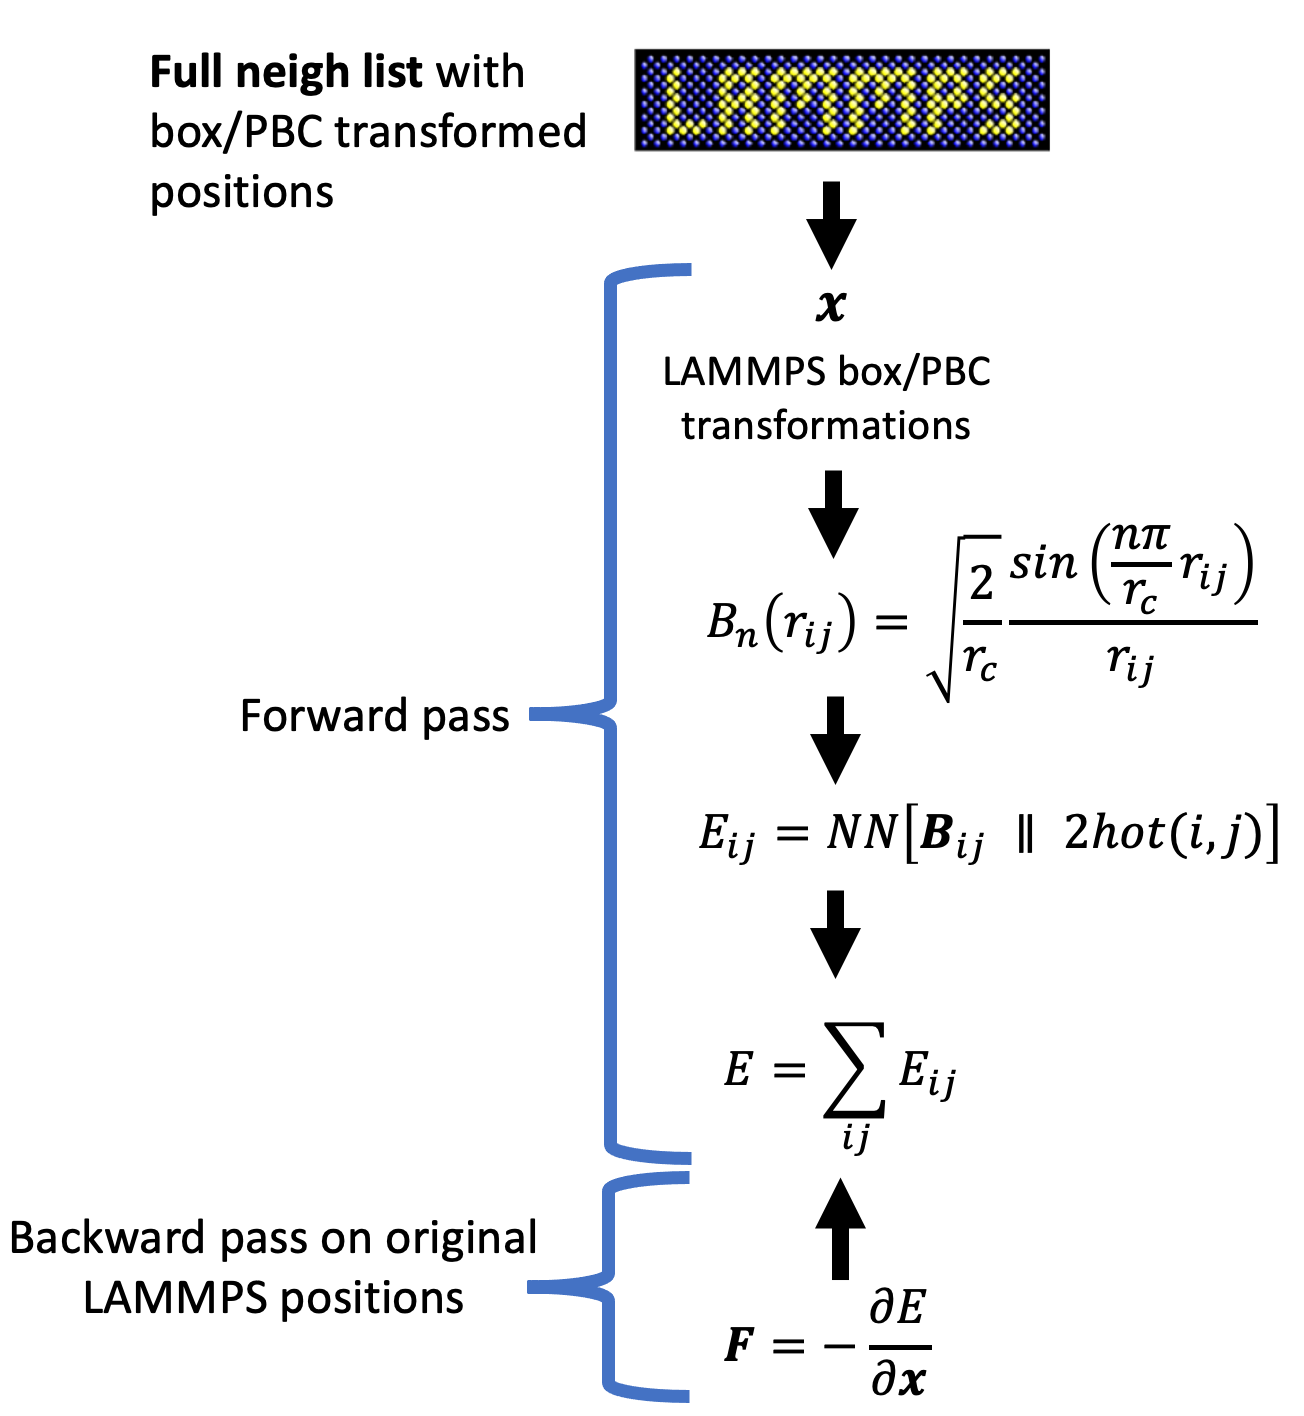


Pros: 

*   "Descriptor" hyperparams get optimized as a part of the computational graph.

Cons:

*   Slower training, need to evaluate descriptors every epoch (might be worth it considering no descriptor hyperparameters).

# Pairwise networks

For this example we will use Bessel function descriptors located in `fitsnap3lib/lib/neural_networks/descriptors/bessel.py`

See `/content/FitSNAP/examples/Ta_pytorch_custom_NN`

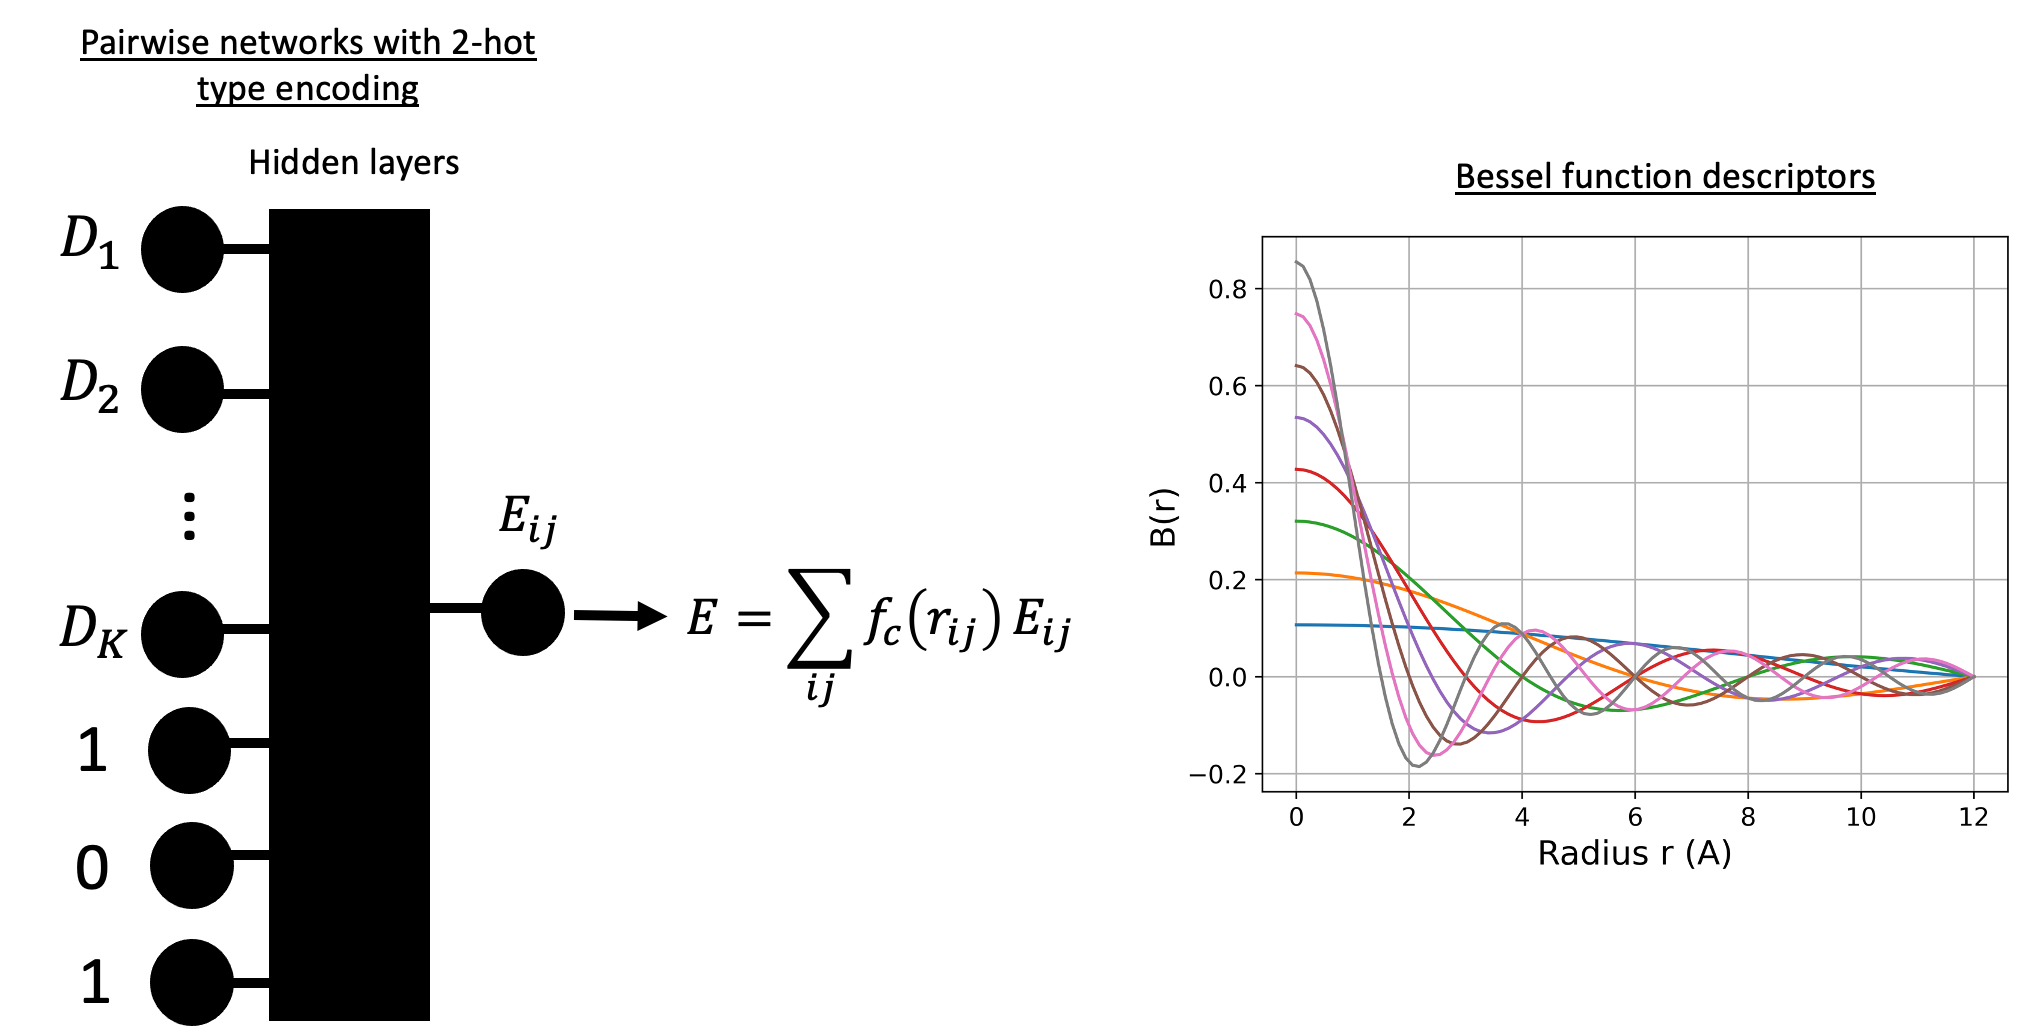


Advantages:

*   General atom-type description allows extension to many atom types.
*   More granularity in interactions (pairwise vs. per-atom) might allow for more flexibility and increased accuracy.



**First thing to check with custom models is that analytical/autograd forces equal finite difference forces:**

In [ ]:
%cd /content/FitSNAP/examples/Ta_pytorch_custom_NN/

from fitsnap3lib.tools.test_tools import TestTools
from fitsnap3lib.io.input import Config
input_script = "Ta-example.in"
test_tool = TestTools(input_script)
test_tool.finite_difference(group="Displaced_BCC")

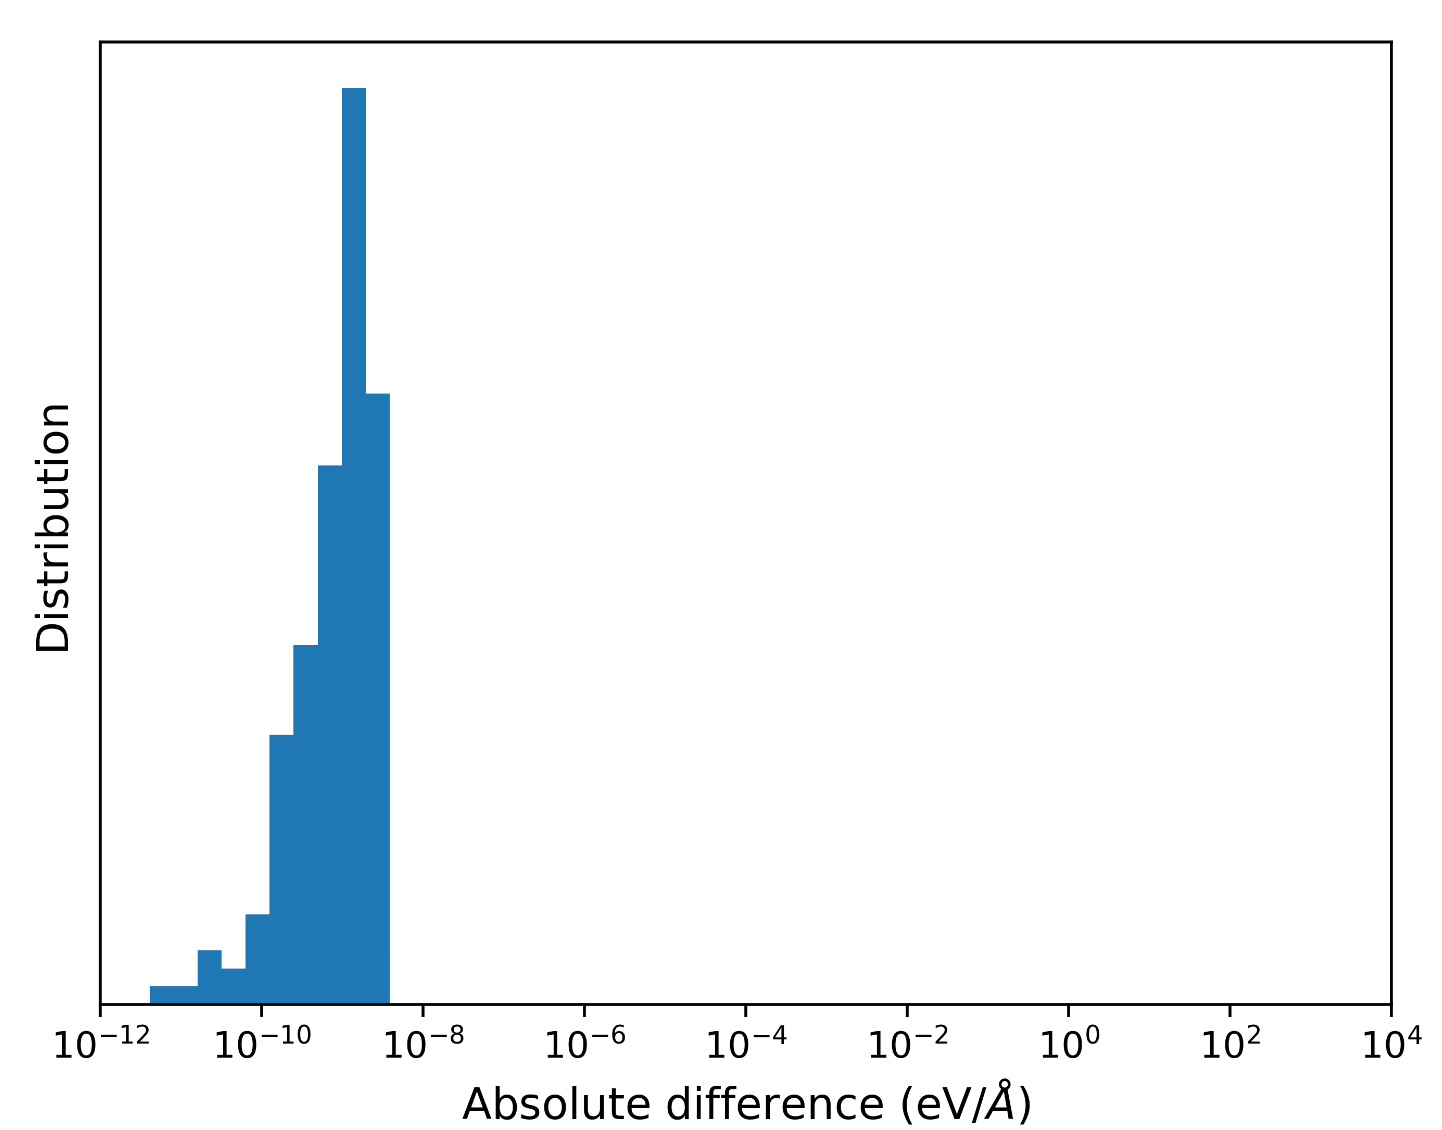

Fit the pairwise network.

In [ ]:
%cd /content/FitSNAP/examples/Ta_pytorch_custom_NN/

!python -m fitsnap3 Ta-example.in --overwrite

The force agreement is less accurate, because it's only a 2-body radial potential.

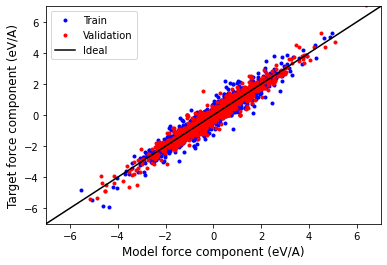

In [ ]:
%cd /content/FitSNAP/examples/Ta_pytorch_custom_NN/

dat = np.loadtxt("force_comparison.dat")
dat_val = np.loadtxt("force_comparison_val.dat")

lims = [-7, 7]
plt.plot(dat[:,0], dat[:,1], 'bo', markersize=3)
plt.plot(dat_val[:,0], dat_val[:,1], 'ro', markersize=3)
plt.plot(lims, lims, 'k-')
plt.legend(["Train", "Validation", "Ideal"])
plt.xlabel("Model force component (eV/A)")
plt.ylabel("Target force component (eV/A)")
plt.xlim(lims[0], lims[1])
plt.ylim(lims[0], lims[1])
plt.show()

The custom networks leave a lot of flexibility and room for creativitiy; they have more granularity in learning different types of interactions. Future development will involve combining these pairwise networks with many-body descriptors to machine learn bond order or reactive potentials. The one-hot encoding of element types is also very favorable for easily studying systems with many types. 